In [16]:
import pathlib
import requests

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import compose, datasets, dummy, ensemble, impute, metrics
from sklearn import model_selection, pipeline, preprocessing, tree

# Boosting methods


## 1. Framing the Problem

In this tutorial you will learn how to apply boosting methods to predict the sales price of a house. House price prediction is a supervised learning, regression problem. The performance measure that you will use is Mean Absolute Percentage error (MAPE).

In [ ]:
metrics.mean_absolute_percentage_error?

In [2]:
SCORING = "neg_mean_absolute_percentage_error"

## 2. Get the data

In [3]:
train_df = pd.read_csv("sample_data/california_housing_train.csv")
test_df = pd.read_csv("sample_data/california_housing_test.csv")

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [5]:
train_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## 3. Exploratory Data Analysis

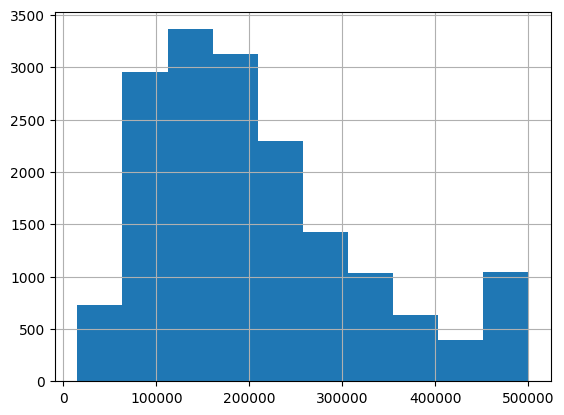

In [70]:
_ = (
    train_df.loc[:, "median_house_value"]
            .hist()
)

In [72]:
(
    train_df.corr()
            .loc[:, "median_house_value"]
)

,median_house_value
longitude,-0.044982
latitude,-0.144917
housing_median_age,0.106758
total_rooms,0.130991
total_bedrooms,0.045783
population,-0.027850
households,0.061031
median_income,0.691871
median_house_value,1.000000


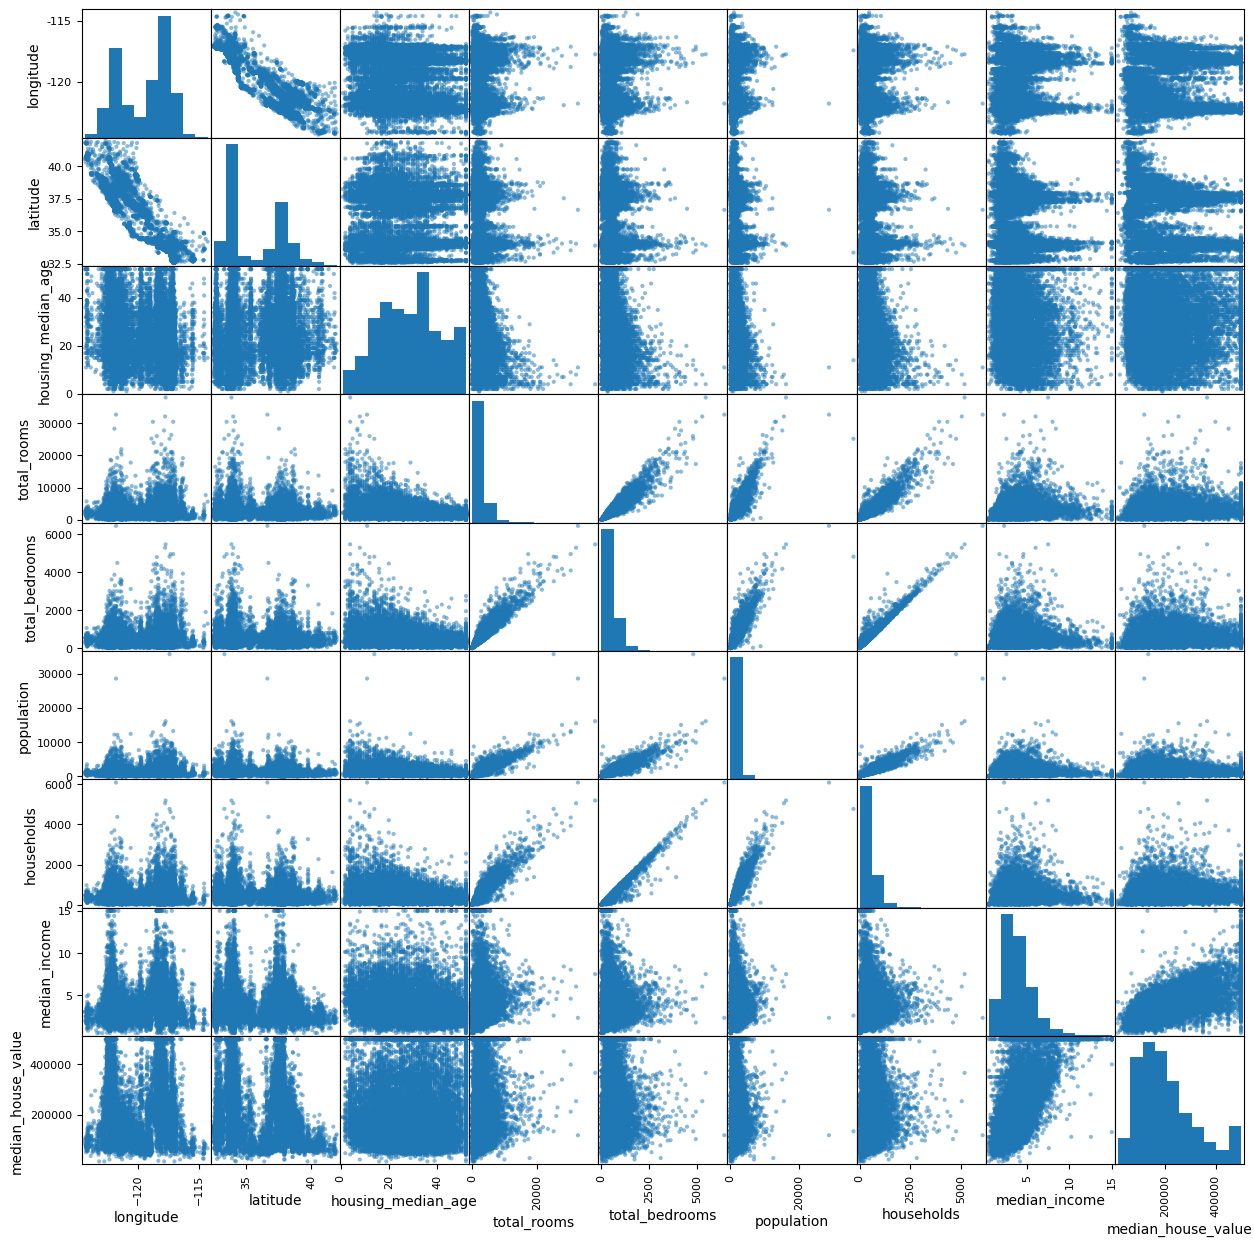

In [76]:
_ = (
    pd.plotting
      .scatter_matrix(
          train_df,
          figsize=(15, 15),
      )
)

## 4. Prepare Data for ML

In [78]:
def remove_outliers(with_outliers_df):
  without_outliers_df = with_outliers_df.query("median_house_value < 500_000")
  return without_outliers_df



In [86]:
new_features = {
    "bedrooms_per_room": train_df.loc[:, "total_bedrooms"] / train_df.loc[:, "total_rooms"],
    "bedrooms_per_household": train_df.loc[:, "total_bedrooms"] / train_df.loc[:, "households"],
    "rooms_per_household": train_df.loc[:, "total_rooms"] / train_df.loc[:, "households"],
    "households_per_person": train_df.loc[:, "households"] / train_df.loc[:, "population"],
    "persons_per_bedroom": train_df.loc[:, "population"] / train_df.loc[:, "total_bedrooms"]
}

(
    train_df.assign(
      **new_features
    ).corr()
     .loc[:, "median_house_value"]
     .sort_values(ascending=True)
)

,median_house_value
bedrooms_per_room,-0.258190
latitude,-0.144917
bedrooms_per_household,-0.045668
longitude,-0.044982
persons_per_bedroom,-0.044105
population,-0.027850
total_bedrooms,0.045783
households,0.061031
housing_median_age,0.106758
total_rooms,0.130991


In [88]:
def feature_engineering(df):
    new_features = {
        "bedrooms_per_room": train_df.loc[:, "total_bedrooms"] / train_df.loc[:, "total_rooms"],
        "bedrooms_per_household": train_df.loc[:, "total_bedrooms"] / train_df.loc[:, "households"],
        "rooms_per_household": train_df.loc[:, "total_rooms"] / train_df.loc[:, "households"],
        "households_per_person": train_df.loc[:, "households"] / train_df.loc[:, "population"],
        "persons_per_bedroom": train_df.loc[:, "population"] / train_df.loc[:, "total_bedrooms"]
    }

    with_new_features_df = (
        df.assign(
            **new_features
        )
    )

    return with_new_features_df



In [89]:
_train_df = remove_outliers(train_df)
_train_df = feature_engineering(_train_df)

train_features_df = _train_df.drop("median_house_value", axis=1)
train_target = _train_df.loc[:, "median_house_value"]

In [90]:
train_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16164 entries, 0 to 16999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   longitude               16164 non-null  float64
 1   latitude                16164 non-null  float64
 2   housing_median_age      16164 non-null  float64
 3   total_rooms             16164 non-null  float64
 4   total_bedrooms          16164 non-null  float64
 5   population              16164 non-null  float64
 6   households              16164 non-null  float64
 7   median_income           16164 non-null  float64
 8   bedrooms_per_room       16164 non-null  float64
 9   bedrooms_per_household  16164 non-null  float64
 10  rooms_per_household     16164 non-null  float64
 11  households_per_person   16164 non-null  float64
 12  persons_per_bedroom     16164 non-null  float64
dtypes: float64(13)
memory usage: 1.7 MB


In [91]:
preprocessing_pipeline = pipeline.make_pipeline(
    impute.SimpleImputer(),
    preprocessing.StandardScaler(),
    verbose=True,
).set_output(transform="pandas")


## 5. Short-list Promising Models

### Benchmark Model

In [92]:
_regressor = dummy.DummyRegressor(
    strategy="median"
)

_transformed_target_regressor = compose.TransformedTargetRegressor(
    _regressor,
    func=np.log,
    inverse_func=np.exp,
)

benchmark_pipeline = pipeline.make_pipeline(
    preprocessing_pipeline,
    _transformed_target_regressor,
    verbose=True,
)

benchmark_cv_scores = model_selection.cross_val_score(
    benchmark_pipeline,
    train_features_df,
    train_target,
    cv=5,
    n_jobs=-1,
    scoring=SCORING
)

print(np.mean(-benchmark_cv_scores * 100))

51.72996497328539


### Adaboost

In [11]:
ensemble.AdaBoostRegressor?

In [93]:
_estimator = tree.DecisionTreeRegressor()

_regressor = ensemble.AdaBoostRegressor(
    estimator=_estimator
)

_transformed_target_regressor = compose.TransformedTargetRegressor(
    _regressor,
    func=np.log,
    inverse_func=np.exp,
)

adaboost_pipeline = pipeline.make_pipeline(
    preprocessing_pipeline,
    _transformed_target_regressor ,
    verbose=True,
)

In [94]:
adaboost_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                 ('standardscaler', StandardScaler())],
                          verbose=True)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=AdaBoostRegressor(estimator=DecisionTreeRegressor())))],
         verbose=True)

In [95]:
cv_scores = model_selection.cross_val_score(
    adaboost_pipeline,
    train_features_df,
    train_target,
    cv=5,
    n_jobs=-1,
    scoring=SCORING
)

In [96]:
np.mean(-cv_scores * 100)

30.321762360912125

### Gradient Boosting

In [19]:
ensemble.GradientBoostingRegressor?

In [97]:
_regressor = ensemble.GradientBoostingRegressor(
    validation_fraction=0.1,
    n_iter_no_change=1,
)

_transformed_target_regressor = compose.TransformedTargetRegressor(
    _regressor,
    func=np.log,
    inverse_func=np.exp,
)

gradient_boosting_pipeline = pipeline.make_pipeline(
    preprocessing_pipeline,
    _transformed_target_regressor,
    verbose=True,
)

In [98]:
gradient_boosting_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                 ('standardscaler', StandardScaler())],
                          verbose=True)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=GradientBoostingRegressor(n_iter_no_change=1)))],
         verbose=True)

In [99]:
cv_scores = model_selection.cross_val_score(
    gradient_boosting_pipeline,
    train_features_df,
    train_target,
    cv=5,
    n_jobs=-1,
    scoring=SCORING
)

In [100]:
np.mean(-cv_scores * 100)

30.5928268325985

### Exercise:

Use early stopping to control the number of estimators (i.e., the number of boosting rounds) for your GradientBoostingRegressor.

In [30]:
ensemble.GradientBoostingRegressor?

#### Solution:

In [31]:
_regressor = ensemble.GradientBoostingRegressor(
    n_iter_no_change=1,
    validation_fraction=0.1,
)

_transformed_target_regressor = compose.TransformedTargetRegressor(
    _regressor,
    func=np.log,
    inverse_func=np.exp,
)

gradient_boosting_pipeline = pipeline.make_pipeline(
    preprocessing_pipeline,
    _transformed_target_regressor,
    verbose=True,
)

cv_scores = model_selection.cross_val_score(
    gradient_boosting_pipeline,
    train_features_df,
    train_target,
    cv=5,
    n_jobs=-1,
    scoring=SCORING
)

np.mean(-cv_scores * 100)

31.90682467656102

### Histogram Gradient Boosting

In [101]:
_regressor = ensemble.HistGradientBoostingRegressor(
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=2,
    monotonic_cst={
        "longitude": -1,
        "latitude": -1,
        "housing_median_age": 0,
        "total_rooms": 0,
        "total_bedrooms": 0,
        "population": 0,
        "households": 0,
        "median_income": 1,
    }
)

_transformed_target_regressor = compose.TransformedTargetRegressor(
    _regressor,
    func=np.log,
    inverse_func=np.exp,
)

hist_gradient_boosting_pipeline = pipeline.make_pipeline(
    preprocessing_pipeline,
    _transformed_target_regressor,
    verbose=True,
)

In [102]:
hist_gradient_boosting_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                 ('standardscaler', StandardScaler())],
                          verbose=True)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=HistGradientBoostingRegressor(early_stopping=True,
                                                                                    monotonic_cst={'households': 0,
                                                                                                   'housing_median_age': 0,
                                                                                                   'latitude': -1,
                                                                                                   'longitude': -1,
                                                                                                   'median_income': 1,
                                                                                                   'population': 0,
                                                                                                   'total_bedrooms': 0,
                                                                                                   'total_rooms': 0},
                                                                                    n_iter_no_change=2)))],
         verbose=True)

In [103]:
cv_scores = model_selection.cross_val_score(
    hist_gradient_boosting_pipeline,
    train_features_df,
    train_target,
    cv=5,
    n_jobs=-1,
    scoring=SCORING
)

In [104]:
np.mean(-cv_scores * 100)

28.686911688769868

## 6. Fine tune the most promising models

### Exercise

Fine tune the best AdaBoostRegressor pipeline.

In [66]:
ensemble.AdaBoostRegressor?

In [68]:
_estimator = tree.DecisionTreeRegressor()

_regressor = ensemble.AdaBoostRegressor(
    estimator=_estimator
)

_transformed_target_regressor = compose.TransformedTargetRegressor(
    _regressor,
    func=np.log,
    inverse_func=np.exp,
)

adaboost_pipeline = pipeline.make_pipeline(
    preprocessing_pipeline,
    _transformed_target_regressor,
    verbose=True,
)

adaboost_grid_search_cv = model_selection.GridSearchCV(
    adaboost_pipeline,
    param_grid={
        "transformedtargetregressor__regressor__learning_rate": [0.001, 0.1, 1.0],
        "transformedtargetregressor__regressor__n_estimators": [25, 50, 100],
        "transformedtargetregressor__regressor__estimator__max_depth": [2, 4, 8, None],
    },
    cv=3,
    n_jobs=-1,
    scoring=SCORING,
    verbose=True
)

_ = adaboost_grid_search_cv.fit(
    train_features_df,
    train_target
)

print(adaboost_grid_search_cv.best_params_)
print(-adaboost_grid_search_cv.best_score_ * 100)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[Pipeline] ..... (step 1 of 2) Processing simpleimputer, total=   0.0s
[Pipeline] .... (step 2 of 2) Processing standardscaler, total=   0.0s
[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   0.0s
[Pipeline]  (step 2 of 2) Processing transformedtargetregressor, total=   6.0s
{'transformedtargetregressor__regressor__estimator__max_depth': None, 'transformedtargetregressor__regressor__learning_rate': 0.1, 'transformedtargetregressor__regressor__n_estimators': 25}
36.34437909936262


### Exercise

Fine tune the GradientBoostingRegressor pipeline

In [ ]:
ensemble.GradientBoostingRegressor?

#### Solution

### Exercise

Fine tune the HistGradientBoostingRegressor pipeline.

In [ ]:
ensemble.HistGradientBoostingRegressor?

#### Solution

In [41]:
ensemble.HistGradientBoostingRegressor?

In [65]:
_regressor = ensemble.HistGradientBoostingRegressor(
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=2,
    monotonic_cst={
        "longitude": -1,
        "latitude": -1,
        "housing_median_age": 0,
        "total_rooms": 0,
        "total_bedrooms": 0,
        "population": 0,
        "households": 0,
        "median_income": 1,
    }
)

_transformed_target_regressor = compose.TransformedTargetRegressor(
    _regressor,
    func=np.log,
    inverse_func=np.exp,
)

hist_gradient_boosting_pipeline = pipeline.make_pipeline(
    preprocessing_pipeline,
    _transformed_target_regressor,
    verbose=True,
)

grid_search_cv = model_selection.GridSearchCV(
    hist_gradient_boosting_pipeline,
    param_grid={
        "transformedtargetregressor__regressor__learning_rate": [0.001, 0.1, 1.0],
        "transformedtargetregressor__regressor__min_samples_leaf": [1, 0.01, 0.1],
    },
    cv=5,
    n_jobs=-1,
    scoring=SCORING,
    verbose=True
)

_ = grid_search_cv.fit(
    train_features_df,
    train_target
)

print(grid_search_cv.best_params_)
print(-grid_search_cv.best_score_ * 100)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[Pipeline] ..... (step 1 of 2) Processing simpleimputer, total=   0.0s
[Pipeline] .... (step 2 of 2) Processing standardscaler, total=   0.0s
[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   0.0s
[Pipeline]  (step 2 of 2) Processing transformedtargetregressor, total=   0.5s
{'transformedtargetregressor__regressor__learning_rate': 0.1, 'transformedtargetregressor__regressor__max_depth': None}
34.70097494401014


{'pipeline': Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())],
          verbose=True),
 'transformedtargetregressor': TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                            regressor=HistGradientBoostingRegressor())}

### Exercise

Compare the performance of the fine tuned gradient boosting models. Which is the best model?

#### Solution

## 7. Summarize your results

### Exercise:

Re-fit your best model on the entire training data set.

#### Solution:

### Exercise:

Generate predictions for the test data using your best pipeline.

#### Solution: